# LSTM Model Training and Testing

This is a Python Notebook that contains the LSTM model training and testing for this MSc thesis.

Student ID: B721581

It is broken down into the following sections:
1. Import Libraries
2. Load Data
3. Data Splitting
4. Sequence Preparation
5. Modifying Shape of Data for LSTM Model
6. Building LSTM Model
7. Training LSTM Model
8. Evaluating LSTM Model

* please note that some of the code will not work as it was made to work for my local computer drive. Therefore it needs editing to run on another machine.
* please also note that this file was edited to train each relevant model for the thesis.

## 1. Import Libraries

In [46]:
# !pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import set_random_seed

set_random_seed(42)

import warnings
warnings.filterwarnings('ignore')

## 2. Load Data

In [47]:
# read the csv file
data = pd.read_csv('data/Preprocessed_Gym_Data.csv')

# convert the workout column to categorical labels
label_encode = LabelEncoder()
data['WorkoutEncode'] = label_encode.fit_transform(data['Workout'].\
                                                   values.ravel())
classes_no = label_encode.classes_.size

# show datset info and statistical description
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2379249 entries, 0 to 2379248
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0.1     int64  
 1   Unnamed: 0       int64  
 2   Object           int64  
 3   Day              int64  
 4   Workout          object 
 5   Sensor_Position  object 
 6   A_x              float64
 7   A_y              float64
 8   A_z              float64
 9   G_x              float64
 10  G_y              float64
 11  G_z              float64
 12  WorkoutEncode    int64  
dtypes: float64(6), int64(5), object(2)
memory usage: 236.0+ MB


,Unnamed: 0.1,Unnamed: 0,Object,Day,A_x,A_y,A_z,G_x,G_y,G_z,WorkoutEncode
count,2.379249e+06,2.379249e+06,2.379249e+06,2.379249e+06,2.379249e+06,2.379249e+06,2.379249e+06,2.379249e+06,2.379249e+06,2.379249e+06,2.379249e+06
mean,2.366582e+06,2.366582e+06,5.393385e+00,2.913315e+00,5.050758e-01,4.980119e-01,4.973124e-01,4.994219e-01,4.995047e-01,5.001717e-01,6.214809e+00
std,1.359626e+06,1.359626e+06,2.848697e+00,1.438409e+00,5.512165e-02,6.330009e-02,3.790589e-02,5.094546e-02,4.437047e-02,5.695197e-02,3.448413e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.179701e+06,1.179701e+06,3.000000e+00,2.000000e+00,4.940000e-01,4.888750e-01,4.917500e-01,4.905438e-01,4.914812e-01,4.851937e-01,4.000000e+00
50%,2.377982e+06,2.377982e+06,5.000000e+00,3.000000e+00,5.001250e-01,4.996250e-01,4.997500e-01,4.999188e-01,5.000000e-01,4.999188e-01,6.000000e+00
75%,3.547161e+06,3.547161e+06,8.000000e+00,4.000000e+00,5.111250e-01,5.075000e-01,5.052500e-01,5.088687e-01,5.084000e-01,5.123813e-01,9.000000e+00
max,4.703188e+06,4.703188e+06,1.000000e+01,5.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.100000e+01


Workout classes and corresponding categorical label
- Adductor = 0
-  ArmCurl = 1 
-  BenchPress = 2
-  LegCurl = 3 
-  LegPress = 4
-  Null = 5
-  Riding = 6
-  RopeSkipping = 7
-  Running = 8
-  Squat = 9
-  StairClimber = 10
-  Walking 11

## 3. Data Splitting

In [48]:
# set variables
participant_cutoff = 8
sensor_position = 'wrist'

# split data into train, val and test:
train_data = data[(data['Object'] < participant_cutoff) &
                  (data['Sensor_Position'] == sensor_position)]

val_data = data[(data['Object'] == participant_cutoff) &
                (data['Sensor_Position'] == sensor_position)]

test_data = data[(data['Object'] > participant_cutoff) &
                 (data['Sensor_Position'] == sensor_position)]

# print shape of each data partition
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(595431, 13)
(84338, 13)
(150219, 13)


## 4. Sequence Preparation

- the following function reshapes the dataframe into the sequences required for the model
- the time period parameter sets the sequence length/window size
- the step distance parameter sets the % overlap of each sequence
- the function also separates the features and labels into the relevant x and y partitions

In [49]:
def segments(df, Time_Period, Step_Distance, label_name):
    no_features = 6
    segments = []
    labels = []
    for i in range(0, len(df) - Time_Period, Step_Distance):
        ax = df['A_x'].values[i:i + Time_Period]
        ay = df['A_y'].values[i:i + Time_Period]
        az = df['A_z'].values[i:i + Time_Period]
        gx = df['G_x'].values[i:i + Time_Period]
        gy = df['G_y'].values[i:i + Time_Period]
        gz = df['G_z'].values[i:i + Time_Period]
        
        label = mode(df[label_name][i:i + Time_Period])[0][0]
        segments.append([ax, ay, az, gx, gy, gz])
        labels.append(label)
    
    reshaped_segments = np.asarray(segments, dtype = np.float32).\
    reshape(-1, Time_Period, no_features)
    labels = np.asarray(labels)
    
    return reshaped_segments, labels

# set variables
time_period = 50
step_distance = 25

# cut each data partition into the set sequences using the function
labels_col = 'WorkoutEncode'
x_train, y_train = segments(train_data, time_period, step_distance, labels_col)
x_val, y_val = segments(val_data, time_period, step_distance, labels_col)
x_test, y_test = segments(test_data, time_period, step_distance, labels_col)

- sequences/window Size = no_time_steps * 0.05 (= 2.5s)
- this is due to 20Hz data colleciton frequency
- overlap % = (no_time_steps - step)/no_time_steps (= 50%)

## 5. Modifying Shape of Data for LSTM Model

In [50]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

y_train_hot = to_categorical(y_train, classes_no)
print("y_train_hot shape: ", y_train_hot.shape)


print("x_val shape: ", x_val.shape)
print("y_val shape: ", y_val.shape)

y_val_hot = to_categorical(y_val, classes_no)
print("y_val_hot shape: ", y_val_hot.shape)


print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

y_test_hot = to_categorical(y_test, classes_no)
print("y_test_hot shape: ", y_test_hot.shape)

x_train shape:  (23816, 50, 6)
y_train shape:  (23816,)
y_train_hot shape:  (23816, 12)
x_val shape:  (3372, 50, 6)
y_val shape:  (3372,)
y_val_hot shape:  (3372, 12)
x_test shape:  (6007, 50, 6)
y_test shape:  (6007,)
y_test_hot shape:  (6007, 12)


## 6. Building LSTM Model

* **It is worth noting that the checkpoint path only works for my local drive and will need to be edited in order for this code chunk to run**

In [51]:
# set variables and hyperparameters
learning_rate = 0.001
hidden_units = 16
layer_no = 1
batch_size = 128
no_epochs = 1
pat = 15
dense_layer = 0
esm = 'val_loss'
version = 1
opt = Adam(learning_rate = learning_rate)

# set regularisation steps (checkpoint saving and early stopping)
checkpoint_path = f'/Users/alexbakker/Dropbox/Alex/Uni - DS MSc/DS Project/\
Coding Drafts/models/model_s{sensor_position}_a{learning_rate}\
_l{layer_no}_h{hidden_units}_dl{dense_layer}_d{dropout}_b{batch_size}\
_tp{time_period}_sd{step_distance}_e{no_epochs}_p{pat}_es{esm}_v{version}.h5'
callbacks = [
      EarlyStopping(monitor = esm, patience = pat, verbose = 1),
      ModelCheckpoint(checkpoint_path, monitor = 'accuracy', 
                      save_best_only = True, verbose = 1)
]

# define the model architecture (uncomment layers when necessary)
model = Sequential([
    #LSTM(units = hidden_units, return_sequences = True, 
    #     input_shape = (x_train.shape[1], x_train.shape[2]), activation = 'relu'),
    #LSTM(units = hidden_units, return_sequences = True, 
    #     input_shape = (x_train.shape[1], x_train.shape[2]), activation = 'relu'),
    #LSTM(units = hidden_units, return_sequences = True, 
    #     input_shape = (x_train.shape[1], x_train.shape[2]), activation = 'relu'),
    #LSTM(units = hidden_units, return_sequences = True, 
    #     input_shape = (x_train.shape[1], x_train.shape[2]), activation = 'relu'),
    LSTM(units = hidden_units, 
         input_shape = (x_train.shape[1], x_train.shape[2]), activation = 'relu'),
    #Dense(units = hidden_units, activation = 'relu'),
    #Dense(units = hidden_units, activation = 'relu'),
    Dense(classes_no, activation = 'softmax')
])

# compile the model and print the summary
model.compile(loss = 'categorical_crossentropy', 
              optimizer = opt, 
              metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 16)                1472      
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 1,676
Trainable params: 1,676
Non-trainable params: 0
_________________________________________________________________
None


## 7. Training LSTM Model

In [52]:
# run the model and save it in variable history
history = model.fit(x_train,
                    y_train_hot,
                    validation_data = [x_val, y_val_hot],
                    batch_size = batch_size,
                    epochs = no_epochs,
                    callbacks = [callbacks],
                    verbose = 1)

187/187 [==============================] - ETA: 0s - loss: 2.4319 - accuracy: 0.1122
Epoch 1: accuracy improved from -inf to 0.11215, saving model to /Users/alexbakker/Dropbox/Alex/Uni - DS MSc/DS Project/Coding Drafts/models/model_swrist_a0.001_l1_h16_dl0_d0_b128_tp50_sd25_e1_p15_esval_loss_v1.h5
187/187 [==============================] - 15s 44ms/step - loss: 2.4319 - accuracy: 0.1122 - val_loss: 2.4333 - val_accuracy: 0.0967


## 8. Evaluating LSTM Model

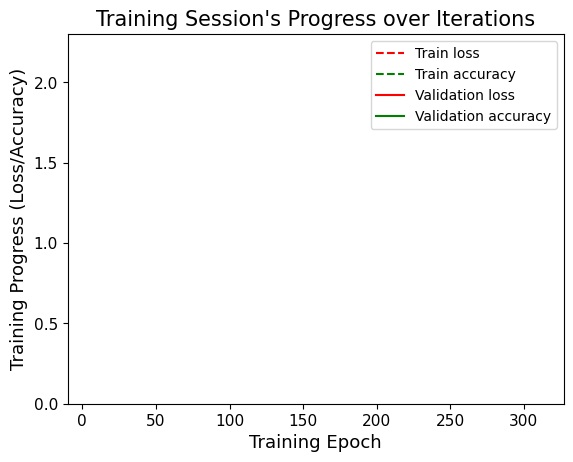

In [53]:
# create plot of model training over time using model history
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", 
         label = "Validation accuracy")
plt.title("Training Session's Progress over Iterations", fontsize = 15)
plt.legend(fontsize = 10)
plt.ylabel('Training Progress (Loss/Accuracy)', fontsize = 13)
plt.xlabel('Training Epoch', fontsize = 13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlim(-10,327)
plt.ylim(-0.1,2.3)
plt.ylim(0)

# save the figure
plt.savefig(f"model_s{sensor_position}_a{learning_rate}_l{layer_no}\
_h{hidden_units}_dl{dense_layer}_d{dropout}_b{batch_size}_tp{time_period}\
_sd{step_distance}_e{no_epochs}_p{pat}_es{esm}_acc_loss_plot_v{version}.png")

# show the plot
plt.show()

In [54]:
# load in the saved model (best model)
saved_model = load_model(checkpoint_path)

# test the model and print the accuracy and loss values
loss, accuracy = saved_model.evaluate(x_test, y_test_hot, 
                                      batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

47/47 [==============================] - 1s 16ms/step - loss: 2.4106 - accuracy: 0.1145
Test Accuracy : 0.11453304439783096
Test Loss : 2.410613775253296


188/188 [==============================] - 3s 11ms/step


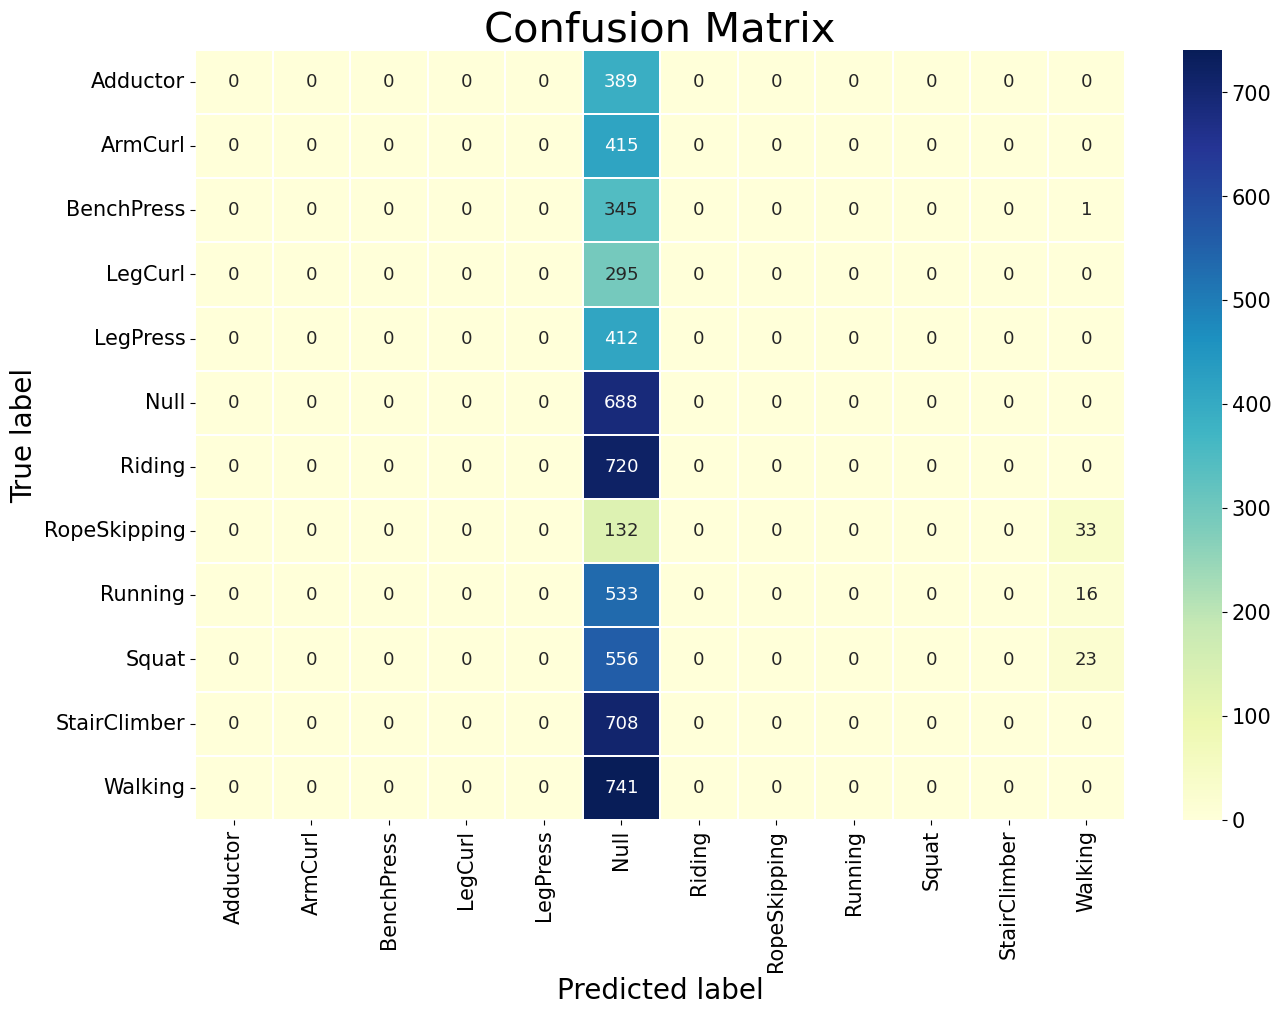

In [55]:
# set variables
fontsize1 = 30
fontsize2 = 20
fontsize3 = 15
FigSize1 = 15
FigSize2 = 10
label_size = 15
annot_size = 13

# test model against test data and create confusion matrix
predictions = saved_model.predict(x_test)
class_labels = list(label_encode.classes_)
max_test = np.argmax(y_test_hot, axis = 1)
max_predictions = np.argmax(predictions, axis = 1)
cm = confusion_matrix(max_test, max_predictions)
fig, ax = plt.subplots(figsize = (FigSize1, FigSize2))
ax = sns.heatmap(cm, xticklabels = class_labels, yticklabels = class_labels, 
                 annot = True, linewidths = 0.1, fmt = 'd', cmap = 'YlGnBu', 
                 annot_kws={"size": annot_size})
plt.title("Confusion Matrix", fontsize = fontsize1)
plt.ylabel('True label', fontsize = fontsize2)
plt.xlabel('Predicted label', fontsize = fontsize2)
plt.yticks(fontsize = fontsize3)
plt.xticks(rotation = 90, fontsize = fontsize3)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=label_size)

# save the figure
plt.savefig(f"model_s{sensor_position}_a{learning_rate}_l{layer_no}\
_h{hidden_units}_dl{dense_layer}_d{dropout}_b{batch_size}_tp{time_period}\
_sd{step_distance}_e{no_epochs}_p{pat}_es{esm}_cm_plot_v{version}.png")

# show the plot
plt.show()

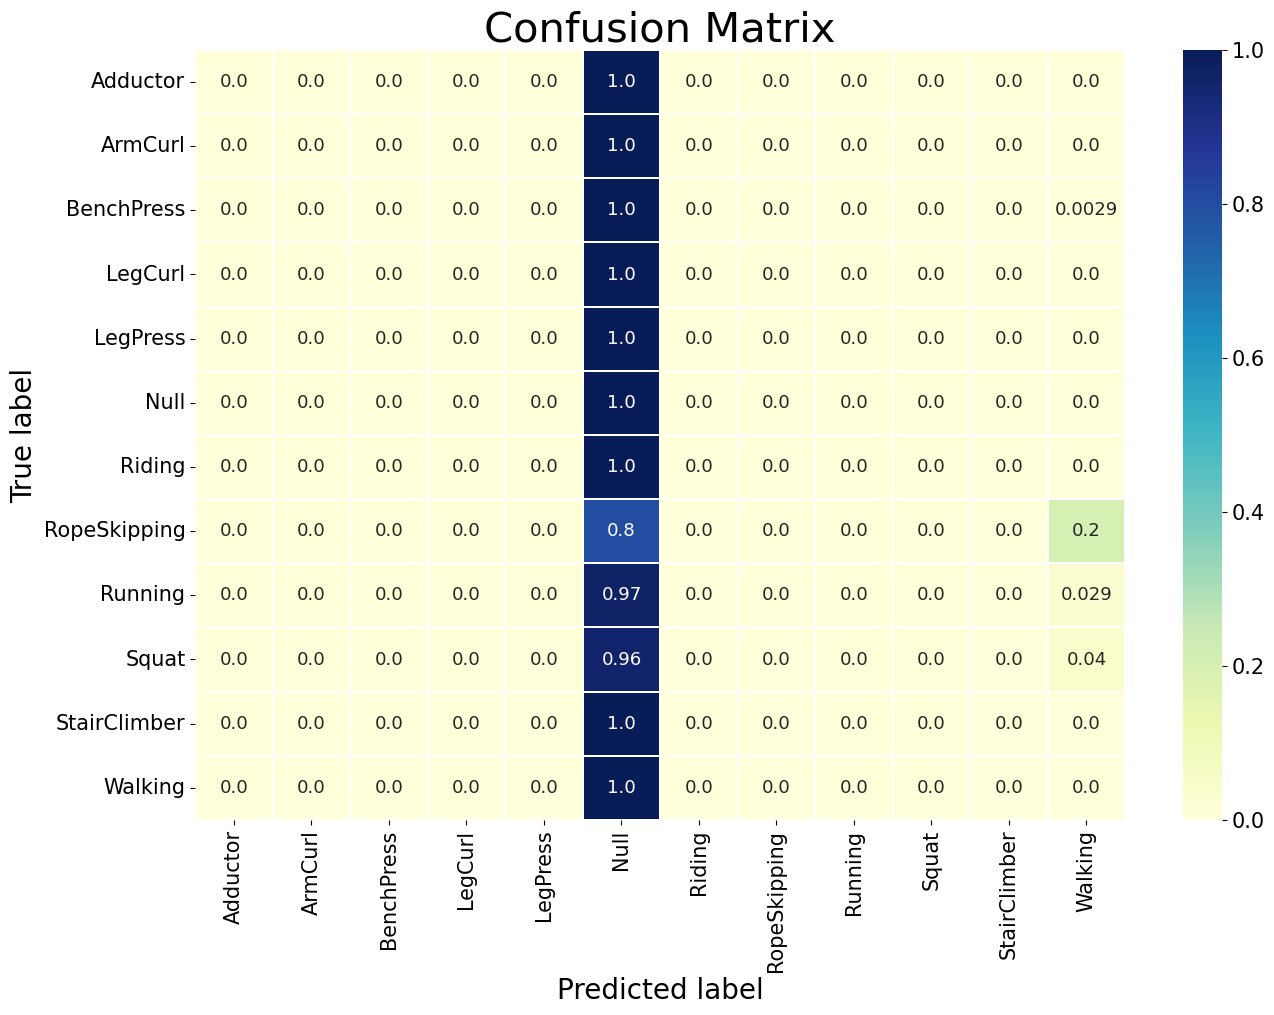

In [56]:
# create normalised confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize = (FigSize1, FigSize2))
ax = sns.heatmap(cmn, xticklabels = class_labels, yticklabels = class_labels, 
                 annot = True, linewidths = 0.1, fmt = '.2', cmap = 'YlGnBu', 
                 annot_kws={"size": annot_size})
plt.title("Confusion Matrix", fontsize = fontsize1)
plt.ylabel('True label', fontsize = fontsize2)
plt.xlabel('Predicted label', fontsize = fontsize2)
plt.yticks(fontsize = fontsize3)
plt.xticks(rotation = 90, fontsize = fontsize3)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=label_size)

# save the figure
plt.savefig(f"model_s{sensor_position}_a{learning_rate}_l{layer_no}\
_h{hidden_units}_dl{dense_layer}_d{dropout}_b{batch_size}_tp{time_period}\
_sd{step_distance}_e{no_epochs}_p{pat}_es{esm}_cmn_plot_v{version}.png")

# show the plot
plt.show()

In [57]:
# get and print the evaluation metrics
predictions = np.argmax(predictions, axis = 1)
y_test_pred = np.argmax(y_test_hot, axis = 1)
print(classification_report(y_test_pred, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       389
           1       0.00      0.00      0.00       415
           2       0.00      0.00      0.00       346
           3       0.00      0.00      0.00       295
           4       0.00      0.00      0.00       412
           5       0.12      1.00      0.21       688
           6       0.00      0.00      0.00       720
           7       0.00      0.00      0.00       165
           8       0.00      0.00      0.00       549
           9       0.00      0.00      0.00       579
          10       0.00      0.00      0.00       708
          11       0.00      0.00      0.00       741

    accuracy                           0.11      6007
   macro avg       0.01      0.08      0.02      6007
weighted avg       0.01      0.11      0.02      6007

